In [1]:
import numpy as np # Library to handle data in a vectorized manner

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # Library to handle JSON files

from geopy.geocoders import Nominatim # Convert an address into latitude and longitude values

import requests # Library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # Map rendering library

#SQL libraries
import ibm_db
import ibm_db_sa
import ibm_db_dbi

In [2]:
%load_ext sql

In [3]:
# Connect to Db2 instance
%sql ibm_db_sa://vcc60770:rzxhtplrb5v0t9%403@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB

'Connected: vcc60770@BLUDB'

In [4]:
df = %sql SELECT * from CRIMES

 * ibm_db_sa://vcc60770:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


In [5]:
%sql select COUNT(*) from CRIMES

 * ibm_db_sa://vcc60770:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


1
533


In [6]:
%sql select COUNT(*) from CRIMES\
    where ARREST = 'TRUE'

 * ibm_db_sa://vcc60770:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


1
163


In [7]:
%sql select DISTINCT PRIMARY_TYPE from CRIMES

 * ibm_db_sa://vcc60770:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


primary_type
ARSON
ASSAULT
BATTERY
BURGLARY
CONCEALED CARRY LICENSE VIOLATION
CRIM SEXUAL ASSAULT
CRIMINAL DAMAGE
CRIMINAL TRESPASS
DECEPTIVE PRACTICE
DOMESTIC VIOLENCE


In [8]:
crime_df = df.DataFrame()
crime_df.head()

,id,case_number,DATE,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area_number,fbicode,x_coordinate,y_coordinate,YEAR,updatedon,latitude,longitude,location
0,3512276,HK587712,2004-08-28 17:50:56,047XX S KEDZIE AVE,890,THEFT,FROM BUILDING,SMALL RETAIL STORE,FALSE,FALSE,911,9,14.0,58.0,6,1155838.0,1873050.0,2004,2018-02-10 15:50:01,41.80744050,-87.70395585,"(41.8074405, -87.703955849)"
1,3406613,HK456306,2004-06-26 12:40:00,009XX N CENTRAL PARK AVE,820,THEFT,$500 AND UNDER,OTHER,FALSE,FALSE,1112,11,27.0,23.0,6,1152206.0,1906127.0,2004,2018-02-28 15:56:25,41.89827996,-87.71640551,"(41.898279962, -87.716405505)"
2,8002131,HT233595,2011-04-04 05:45:00,043XX S WABASH AVE,820,THEFT,$500 AND UNDER,NURSING HOME/RETIREMENT HOME,FALSE,FALSE,221,2,3.0,38.0,6,1177436.0,1876313.0,2011,2018-02-10 15:50:01,41.81593313,-87.62464213,"(41.815933131, -87.624642127)"
3,7903289,HT133522,2010-12-30 16:30:00,083XX S KINGSTON AVE,840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,FALSE,FALSE,423,4,7.0,46.0,6,1194622.0,1850125.0,2010,2018-02-10 15:50:01,41.74366532,-87.56246276,"(41.743665322, -87.562462756)"
4,10402076,HZ138551,2016-02-02 19:30:00,033XX W 66TH ST,820,THEFT,$500 AND UNDER,ALLEY,FALSE,FALSE,831,8,15.0,66.0,6,1155240.0,1860661.0,2016,2018-02-10 15:50:01,41.77345530,-87.70648047,"(41.773455295, -87.706480471)"


In [9]:
census = %sql select * from CENSUS
census_df = census.DataFrame()
census_df = census_df[['community_area_name','community_area_number']].dropna()
census_df.head()

 * ibm_db_sa://vcc60770:***@dashdb-txn-sbox-yp-dal09-08.services.dal.bluemix.net:50000/BLUDB
Done.


,community_area_name,community_area_number
0,Rogers Park,1.0
1,West Ridge,2.0
2,Uptown,3.0
3,Lincoln Square,4.0
4,North Center,5.0


In [10]:
merged_df = pd.merge(crime_df,census_df,left_on='community_area_number',right_on='community_area_number').reset_index(drop=True).dropna()
merged_df.head()

,id,case_number,DATE,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area_number,fbicode,x_coordinate,y_coordinate,YEAR,updatedon,latitude,longitude,location,community_area_name
0,3512276,HK587712,2004-08-28 17:50:56,047XX S KEDZIE AVE,890,THEFT,FROM BUILDING,SMALL RETAIL STORE,FALSE,FALSE,911,9,14.0,58.0,6,1155838.0,1873050.0,2004,2018-02-10 15:50:01,41.80744050,-87.70395585,"(41.8074405, -87.703955849)",Brighton Park
1,7937542,HT169840,2011-02-18 19:30:00,029XX W 36TH ST,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE-GARAGE,FALSE,FALSE,913,9,12.0,58.0,14,1157190.0,1880621.0,2011,2018-02-10 15:50:01,41.82818901,-87.69879200,"(41.828189011, -87.698792003)",Brighton Park
2,7881407,HT112422,2011-01-09 18:27:00,039XX S ROCKWELL ST,1310,CRIMINAL DAMAGE,TO PROPERTY,RESIDENCE,FALSE,FALSE,914,9,12.0,58.0,14,1159685.0,1878264.0,2011,2016-02-04 06:33:39,41.82167019,-87.68970283,"(41.821670189, -87.689702831)",Brighton Park
3,10770065,HZ535494,2016-11-30 22:00:00,033XX W 38TH ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,FALSE,FALSE,911,9,12.0,58.0,14,1154734.0,1879205.0,2016,2018-02-10 15:50:01,41.82435275,-87.70784072,"(41.824352752, -87.707840716)",Brighton Park
4,7502426,HS305355,2010-05-13 11:00:00,035XX S WASHTENAW AVE,1821,NARCOTICS,MANU/DEL:CANNABIS 10GM OR LESS,"SCHOOL, PUBLIC, BUILDING",TRUE,FALSE,913,9,12.0,58.0,18,1158944.0,1880896.0,2010,2018-02-10 15:50:01,41.82890791,-87.69234919,"(41.828907913, -87.692349187)",Brighton Park


In [11]:
chicago_df = merged_df[['id','primary_type', 'latitude', 'longitude', 'community_area_name']]
chicago_df.head()

,id,primary_type,latitude,longitude,community_area_name
0,3512276,THEFT,41.80744050,-87.70395585,Brighton Park
1,7937542,CRIMINAL DAMAGE,41.82818901,-87.69879200,Brighton Park
2,7881407,CRIMINAL DAMAGE,41.82167019,-87.68970283,Brighton Park
3,10770065,CRIMINAL DAMAGE,41.82435275,-87.70784072,Brighton Park
4,7502426,NARCOTICS,41.82890791,-87.69234919,Brighton Park


In [12]:
address = 'Chicago, IL'

geolocator = Nominatim(user_agent="il_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


In [13]:
# create map of Chicago using latitude and longitude values
map_chicago = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers of incident locations to map
for lat, lng, community, crime in zip(chicago_df['latitude'], chicago_df['longitude'], chicago_df['community_area_name'], chicago_df['primary_type']):
    label = '{}, {}'.format(community, crime)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chicago)  
    
map_chicago

In [23]:
CLIENT_ID = 'BAZCOY2HNEDY5YKC0BKYLNLQRRTW4VV0VZPJVI2RWXJGLZMH'
CLIENT_SECRET = 'KYRLXKWKTIRIV1P3Z2FVLAZLUENARRUPOS4VHBZCH2ZIBF1Z' 
VERSION = '20180605'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BAZCOY2HNEDY5YKC0BKYLNLQRRTW4VV0VZPJVI2RWXJGLZMH
CLIENT_SECRET:KYRLXKWKTIRIV1P3Z2FVLAZLUENARRUPOS4VHBZCH2ZIBF1Z


In [24]:
community_latitude = chicago_df.loc[0, 'latitude'] # community latitude value
community_longitude = chicago_df.loc[0, 'longitude'] # community longitude value

community_name = chicago_df.loc[0, 'community_area_name'] # community name

print('Latitude and longitude values of {} are {}, {}.'.format(community_name, 
                                                               community_latitude, 
                                                               community_longitude))

Latitude and longitude values of Brighton Park are 41.80744050, -87.70395585.


In [25]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    community_latitude, 
    community_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=BAZCOY2HNEDY5YKC0BKYLNLQRRTW4VV0VZPJVI2RWXJGLZMH&client_secret=KYRLXKWKTIRIV1P3Z2FVLAZLUENARRUPOS4VHBZCH2ZIBF1Z&v=20180605&ll=41.80744050,-87.70395585&radius=500&limit=100'

In [26]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5eadceecb1cac0001b8e9069'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Brighton Park',
  'headerFullLocation': 'Brighton Park, Chicago',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 31,
  'suggestedBounds': {'ne': {'lat': 41.8119405045, 'lng': -87.6979300033007},
   'sw': {'lat': 41.802940495499996, 'lng': -87.7099816966993}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b93f135f964a520975b34e3',
       'name': "Pete's Fresh Market",
       'location': {'address': '4700 S Kedzie Ave',
        'lat': 41.80776733903465,
        'lng': -87.7042837308118,
        'labeledLatLngs': 

In [27]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Pete's Fresh Market,Grocery Store,41.807767,-87.704284
1,Carnitas Don Rafa,Mexican Restaurant,41.809206,-87.703963
2,LaCoco's Pizza & Pasta,Italian Restaurant,41.808380,-87.708364
3,Town & Country Self-Service Liquor Mart,Liquor Store,41.808341,-87.698332
4,T.J. Maxx,Department Store,41.803621,-87.705262


In [29]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

31 venues were returned by Foursquare.


In [30]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [31]:
chicago_venues = getNearbyVenues(names=chicago_df['community_area_name'],
                                   latitudes=chicago_df['latitude'],
                                   longitudes=chicago_df['longitude']
                                  )

print(chicago_venues.shape) # please note: this might return an error if number of allowed daily requests are exceeded

Brighton Park
Brighton Park
Brighton Park
Brighton Park
Brighton Park
Brighton Park
Brighton Park
Brighton Park
Brighton Park
Brighton Park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Humboldt park
Grand Boulevard
Grand Boulevard
Grand Boulevard
Grand Boulevard
Grand Boulevard
Grand Boulevard
Grand Boulevard
Grand Boulevard
South Chicago
South Chicago
South Chicago
South Chicago
South Chicago
South Chicago
South Chicago
South Chicago
South Chicago
Chicago Lawn
Chicago Lawn
Chicago Lawn
Chicago Lawn
Chicago Lawn
Chicago Lawn
Chicago Lawn
Chicago Lawn
Chicago Lawn
Chicago Lawn
Chicago Lawn
Chicago Lawn
West Town
West Town
West Town
West Town
West Town
West Town
West Town
West Town
West Town
West Town
West Town
West Town
West Town
Albany Park
Albany Park
Al

In [32]:
chicago_venues.head()

,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Brighton Park,41.80744050,-87.70395585,Pete's Fresh Market,41.807767,-87.704284,Grocery Store
1,Brighton Park,41.80744050,-87.70395585,Carnitas Don Rafa,41.809206,-87.703963,Mexican Restaurant
2,Brighton Park,41.80744050,-87.70395585,LaCoco's Pizza & Pasta,41.808380,-87.708364,Italian Restaurant
3,Brighton Park,41.80744050,-87.70395585,Town & Country Self-Service Liquor Mart,41.808341,-87.698332,Liquor Store
4,Brighton Park,41.80744050,-87.70395585,T.J. Maxx,41.803621,-87.705262,Department Store


In [33]:
chicago_venues.groupby('Community').count()

,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Community,,,,,,
Albany Park,134,134,134,134,134,134
Ashburn,52,52,52,52,52,52
Auburn Gresham,113,113,113,113,113,113
Austin,363,363,363,363,363,363
Avalon Park,55,55,55,55,55,55
Avondale,217,217,217,217,217,217
Belmont Cragin,80,80,80,80,80,80
Beverly,69,69,69,69,69,69
Bridgeport,19,19,19,19,19,19


In [34]:
print('There are {} uniques categories.'.format(len(chicago_venues['Venue Category'].unique())))

There are 385 uniques categories.


In [35]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add community column back to dataframe
chicago_onehot['Community'] = chicago_venues['Community'] 

# move community column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

,Community,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Classroom,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pilates

In [36]:
chicago_grouped = chicago_onehot.groupby('Community').mean().reset_index()
chicago_grouped

,Community,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Classroom,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pie Shop,Pilates

In [37]:
num_top_venues = 5

for hood in chicago_grouped['Community']:
    print("----"+hood+"----")
    temp = chicago_grouped[chicago_grouped['Community'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albany Park----
                       venue  freq
0         Mexican Restaurant  0.09
1                Bus Station  0.06
2                     Bakery  0.04
3  Middle Eastern Restaurant  0.04
4                Pizza Place  0.04


----Ashburn----
               venue  freq
0               Park  0.13
1        Pizza Place  0.10
2  Martial Arts Dojo  0.04
3       Liquor Store  0.04
4             Bakery  0.04


----Auburn Gresham----
                  venue  freq
0        Discount Store  0.10
1              Pharmacy  0.08
2    Seafood Restaurant  0.07
3  Fast Food Restaurant  0.05
4    Chinese Restaurant  0.04


----Austin----
                  venue  freq
0  Fast Food Restaurant  0.07
1        Sandwich Place  0.06
2                  Park  0.05
3   Fried Chicken Joint  0.05
4             BBQ Joint  0.05


----Avalon Park----
                  venue  freq
0  Fast Food Restaurant  0.13
1          Burger Joint  0.09
2        Sandwich Place  0.07
3                 Diner  0.05
4   Fried Chicke

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Community']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
community_venues_sorted = pd.DataFrame(columns=columns)
community_venues_sorted['Community'] = chicago_grouped['Community']

for ind in np.arange(chicago_grouped.shape[0]):
    community_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

community_venues_sorted.head()

,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Mexican Restaurant,Bus Station,Middle Eastern Restaurant,Bakery,Pizza Place,Park,Ice Cream Shop,Grocery Store,Asian Restaurant,Train Station
1,Ashburn,Park,Pizza Place,Mexican Restaurant,Liquor Store,Bus Station,Martial Arts Dojo,Cosmetics Shop,Bakery,Grocery Store,Bar
2,Auburn Gresham,Discount Store,Pharmacy,Seafood Restaurant,Fast Food Restaurant,Sandwich Place,Chinese Restaurant,Lounge,Liquor Store,Grocery Store,Convenience Store
3,Austin,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint,Park,BBQ Joint,Discount Store,Chinese Restaurant,Grocery Store,Seafood Restaurant,Donut Shop
4,Avalon Park,Fast Food Restaurant,Burger Joint,Sandwich Place,Grocery Store,Fried Chicken Joint,Diner,ATM,Home Service,Dry Cleaner,Discount Store


In [40]:
# set number of clusters
kclusters = 5

chicago_grouped_clustering = chicago_grouped.drop('Community', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 2, 2, 2, 0, 0, 2, 0, 0])

In [41]:
# add clustering labels
community_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [42]:
chicago_merged = chicago_df

# merge chicago_merged with chicago_df to add latitude/longitude for each community
chicago_merged = chicago_merged.join(community_venues_sorted.set_index('Community'), on='community_area_name')

chicago_merged.sort_values('primary_type').head()

,id,primary_type,latitude,longitude,community_area_name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
467,4607081,ARSON,41.67980945,-87.62587044,West Pullman,3,Bar,Bus Station,Food,Train Station,Historic Site,Convenience Store,Resort,Bakery,Coffee Shop,Asian Restaurant
453,9692995,ARSON,41.65371054,-87.60952871,Riverdale,4,Harbor / Marina,Park,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market
396,4681320,ASSAULT,41.75501329,-87.66598631,Auburn Gresham,2,Discount Store,Pharmacy,Seafood Restaurant,Fast Food Restaurant,Sandwich Place,Chinese Restaurant,Lounge,Liquor Store,Grocery Store,Convenience Store
397,3661130,ASSAULT,41.74047635,-87.65468280,Auburn Gresham,2,Discount Store,Pharmacy,Seafood Restaurant,Fast Food Restaurant,Sandwich Place,Chinese Restaurant,Lounge,Liquor Store,Grocery Store,Convenience Store
431,10502099,ASSAULT,41.87014181,-87.69703716,East Garfield Park,2,Discount Store,Diner,Pharmacy,American Restaurant,Food,Southern / Soul Food Restaurant,Bus Line,Park,Supermarket,Liquor Store


In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, poi, crime, cluster in zip(chicago_merged['latitude'], chicago_merged['longitude'], chicago_merged['community_area_name'],chicago_merged['primary_type'], chicago_merged['Cluster Labels']):
    label = '{}, {}'.format(poi, crime)
    label = folium.Popup(label + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [44]:
# select rows by cluster and include columns 2 - 15
cluster0 = chicago_merged.loc[chicago_merged['Cluster Labels'] == 0, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]] 
print(cluster0.shape)

(249, 12)


In [45]:
cluster1 = chicago_merged.loc[chicago_merged['Cluster Labels'] == 1, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]
print(cluster1.shape)

(1, 12)


In [46]:
cluster2 = chicago_merged.loc[chicago_merged['Cluster Labels'] == 2, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]
print(cluster2.shape)

(228, 12)


In [47]:
cluster3 = chicago_merged.loc[chicago_merged['Cluster Labels'] == 3, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]
print(cluster3.shape)

(7, 12)


In [48]:
cluster4 = chicago_merged.loc[chicago_merged['Cluster Labels'] == 4, chicago_merged.columns[[1] + list(range(5, chicago_merged.shape[1]))]]
print(cluster4.shape)

(2, 12)


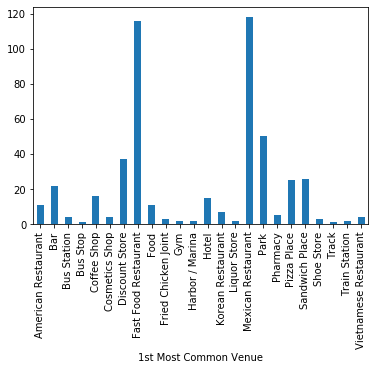

In [87]:
chicago_merged.groupby('1st Most Common Venue')['primary_type'].count().plot(kind='bar')

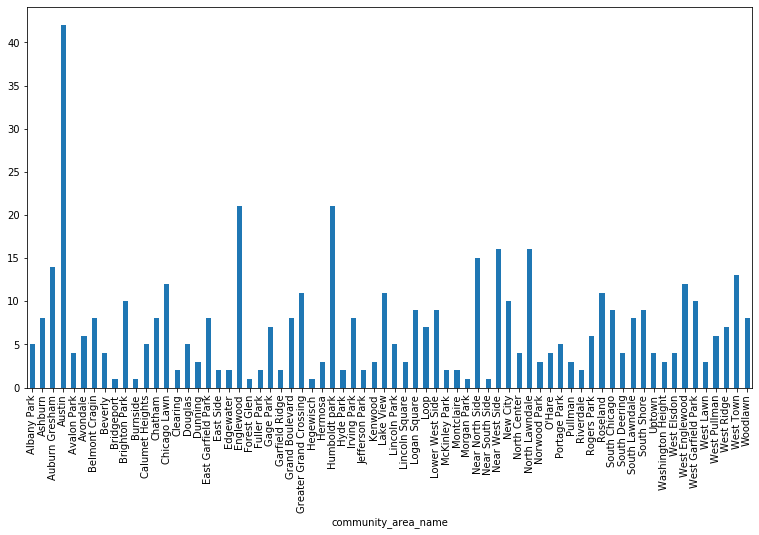

In [81]:
plt.figure(figsize=(13,7))
chicago_merged.groupby('community_area_name')['primary_type'].count().plot(kind='bar')